In [1]:
pair={"[":"]","{":"}","(":")"}
opCode={"+":"ADD","-":"SUB","*":"MUL","\\":"DIV"}
opRel={">":"bgt",">=":"bge","<":"blt","<=":"ble","==":"beq","!=":"bnq"}
import networkx as nx

In [2]:
class Result():
    def __init__(self, kind=None,val=None,address=None,regno=None,real_value=None):
        self.kind = kind
        self.val = val
        self.address = address
        self.regno=regno
        self.real_value=real_value
        
    def __repr__(self):
        return "$"+str(self.kind) + str(self.val) + str(self.address) + str(self.regno) + str(self.real_value) +"$"

In [3]:
def Parenthesize(x,y=None):
    if y==None:
        return "("+str(x)+")"
    else:
        return "("+str(x) + "," + str(y) +")"

TEMP_VARIABLE_CORE="temp+for+internalUse"
class Random_variable_gen():
    def __init__(self):
        def _counter():
            for i in range(1,10000000):
                yield i
            else:
                print("tooooo many temp variables")
        self.a=_counter()
        self._current=self.next()
        
    def next(self):
        self._current=TEMP_VARIABLE_CORE+str(next(self.a))
        return self._current
    
    def get_current_random_variable(self):
        return self._current        
        
#def get_random_variable():
#test:
b=Random_variable_gen()
print(b.next())
print(b.next(),b.get_current_random_variable())    

temp+for+internalUse2
('temp+for+internalUse3', 'temp+for+internalUse3')


In [4]:
class Reg():
    def __init__(self):
        self.num=5
        self.occ= [0]*self.num 
        
    def AllocateReg(self):pass
    def DeAllocateReg(self,i):pass        
    def emit(self,bb,op,x=None,y=None):pass
    def load(self,x,bb): pass #get from the parser_compute

In [5]:
class parser_util():
    def __init__(self):
        pass
    
    def check_computation(self):
        self.must_parse("main")
        #more than 0
        while self.tokens[0].type in ["var","array"]:
            self.check_varDecl()
        #more than 0
        while self.tokens[0].type in ["function","procedure"]:
            self.check_funcDecl()
        bb=self.new_bb([])
        self.must_parse("OPEN_C")        
        bb=self.check_stat_Sequence(bb)
        self.must_parse("CLOSE_C")
        self.must_parse("POINT")
        
    def check_funcDecl(self):

        if self.tokens[0].type=="function":
            self.must_parse("function")
        else:
            self.must_parse("procedure")
        
        bb=self.new_bb([])

        self.must_parse("INDENT")
        self.check_formalParam()
        self.must_parse("SEMI")
        self.check_funcBody(bb)
        self.must_parse("SEMI")
        
    def check_formalParam(self):
        if self.tokens[0].type=="OPEN_P":
            self.must_parse("OPEN_P")
            if self.tokens[0].type=="INDENT":
                self.must_parse("INDENT")
                #more than 0
                while self.tokens[0].type=="COMMA":            
                    self.must_parse("COMMA")
                    self.must_parse("INDENT")
            self.must_parse("CLOSE_P")
         
    def check_funcBody(self,bb):
        while self.tokens[0].type in ["var","array"]:
            self.check_varDecl()
        self.must_parse("OPEN_C")        
        bb=self.check_stat_Sequence(bb)
        self.must_parse("CLOSE_C")

    def check_relation(self,bb):
        result_x,_=self.check_expression(bb)
        op=self.tokens[0].value
        self.check_relOp()
        result_y,_=self.check_expression(bb)
        self.compute_SSA(result_x,result_y,"CMP",bb)
        return op
        
        
    def check_relOp(self):
        if self.tokens[0].type in ['OP_EQ','OP_NEQ','OP_LESS','OP_LEQ','OP_GRT','OP_GEREQ']:
            self.must_parse(self.tokens[0].type)
        else:
            print("error in cheching relOp!",self.tokens[0].type)
        
    def must_parse(self,target_token):        
        sym=self.tokens.popleft()
        if (sym.type==target_token):
            if sym.type=="INDENT":
                print(sym.value),
            pass
        else:
            print("error!!!!!",target_token,sym,inspect.stack()[1][3])
            print([i.value for i in self.tokens])  
        
    
    def check_returnStatement(self,bb):
        self.must_parse("return")
        #how?
        if self.tokens[0].type in ["INDENT","NUMBER","OPEN_P","call"]:
            self.check_expression(bb)
    
    def check_designator(self,bb):
        indent=self.tokens[0].real_value
        self.must_parse("INDENT")        
        while self.tokens[0].type=="OPEN_B":
            self.must_parse("OPEN_B")
            self.check_expression(bb)
            self.must_parse("CLOSE_B")
        return indent
    
    def check_term(self,bb):
        copy_propagation=True
        result_x,copy_propagation=self.check_factor(bb)
        while self.tokens[0].value in ["*","/"]:
            copy_propagation=False
            op=self.tokens[0].value
            self.must_parse("OP")
            result_y,_=self.check_factor(bb)
            result_x=self.compute_SSA(result_x,result_y,op,bb)
            if result_x.kind!="constant":
                result_x.real_value=self.Random_variable.get_current_random_variable()                
                self.add_SSA_table(result_x.real_value,bb)
        self.Random_variable.next()
        return result_x,copy_propagation

    def check_funcCall(self):
        bb=0
        self.must_parse("call")
        self.must_parse("INDENT")
        if self.tokens[0].type=="OPEN_P":
            self.must_parse("OPEN_P")
            #how?
            if self.tokens[0].type in ["INDENT","NUMBER","OPEN_P","call"]:
                self.check_expression(bb)
                while self.tokens[0].type=="COMMA":
                        self.must_parse("COMMA")
                        self.check_expression(bb)
            self.must_parse("CLOSE_P")
        
    def check_varDecl(self):
        self.check_typeDecl()
        self.must_parse("INDENT")
        #more than 0 var
        while self.tokens[0].type in ["COMMA"]:
            self.must_parse("COMMA")            
            self.must_parse("INDENT")
        self.must_parse("SEMI")

        
    def check_typeDecl(self):
        if self.tokens[0].type=="array":
            self.must_parse("array")
            counter=0
            #more than 1
            while self.tokens[0].type=="OPEN_B":
                self.must_parse("OPEN_B")
                self.must_parse("NUMBER")
                self.must_parse("CLOSE_B")
                counter+=1
            if counter==0:
                print("error typeDecl",self.tokens[0].type)
                
        elif self.tokens[0].type=="var":
            self.must_parse("var")
        else:
            print("error typeDecl",target_token,self.tokens[0].type)
        
    def check_stat_Sequence(self,bb):
        bb=self.check_statement(bb)
        # more that 0
        while self.tokens[0].type in ["SEMI"]:
            self.must_parse("SEMI")            
            bb=self.check_statement(bb)
        return bb
            
    def check_statement(self,bb):
        if self.tokens[0].type not in ["let","call","if","while","return"]:
            print("error check_statement",self.tokens[0].type,inspect.stack()[1][3])
        if self.tokens[0].type=="let":
            self.check_assignment(bb)
        if self.tokens[0].type=="call":
            self.check_funcCall()
        if self.tokens[0].type=="if":
            bb=self.check_ifStatement(bb)
        if self.tokens[0].type=="while":
            bb=self.check_whileStatement(bb)
        if self.tokens[0].type=="return":
            self.check_returnStatement(bb)
        return bb

In [6]:
#SSA_code: [SSA_number:,op:,x:,y:,str:]
class SSA_code():
    def __init__(self,SSA_number=0,op=None,x=None,y=None):
        self.SSA_number=SSA_number
        self.op=op
        self.x=x
        self.y=y        
    def __repr__(self):
        return Parenthesize(self.SSA_number)+" "+ str(self.op) +" "+ str(self.x) +", "+ str(self.y)
    def __eq__(self,i):
        # (i) add r1,r2 and (j) add r2,r1 are the same?
        return self.op==i.op and self.x==i.x and self.y==i.y
    

In [7]:
#self.node[self.number]["code"]
class BB(SSA_code):
    def __init__(self):
        self.node=defaultdict(lambda: defaultdict(list))
        self.number=0
        self.G=None
        self.entry_node=[1]
        
    def _get_BB_first_SSA_number(self,bb):
        first_line="where?"
        try:
            first_line=self.node[bb]["code"][0].SSA_number
        except:
            try: #in the case there is no SSA code in the target BB, we add an empty line to it
                self.emit2(bb,"None","For the sake of IF")
                first_line=self.node[bb]["code"][0].SSA_number
            except:
                print("!!! could not find the first line of block:",bb)                
        return first_line
    
    def new_bb(self,parents):
        self.number=self.number+1
        self.node[self.number]["parents"]=parents
        self.node[self.number]["code"]=[]
        self.node[self.number]["live"]=set()
        self.node[self.number]["SSA_table"]=defaultdict(list)
        self.copy_SSA_table(self.number)
        return self.number
    
    def build_graph(self):
        self.G=nx.DiGraph()
        for i in self.node.keys():
            self.G.add_node(i, label=str(i))
        for i in self.node.keys():
            for j in self.node[i]["parents"]:
                self.G.add_edge(j,i)
    
    def dom_pair(self,i):
        a=nx.immediate_dominators(self.G, i).items()
        return a
    
    def all_dom_pair(self):
        for entry_n in self.entry_node:
            a=self.dom_pair(entry_n)
            print("dom_tree from entry node,",entry_n,a)
            d=collections.defaultdict(list)
            
            a= [(y,x) for x,y in nx.immediate_dominators(self.G, entry_n).items()]
            G_dominator=nx.DiGraph(a)
            
            #cc=nx.dfs_successors(G_dominator, source=entry_n)
            cc=nx.descendants(G_dominator,source=entry_n)
            print("Dom treee_reachable from node:",entry_n,cc)
            for i in cc:
                cse_result=self.check_CSE(entry_n,i)
                for ii in cse_result:
                    self.remove_cse(ii)    
    
    def compute_dominator(self):
        G=nx.DiGraph()
        for i in self.node.keys():
            G.add_node(i, label=str(i))
        for i in self.node.keys():
            for j in self.node[i]["parents"]:
                G.add_edge(j,i)
        G_dominator=nx.DiGraph()
        
        #is this correct? Do we have to inegrate the graphs?
        All_t=True
        import matplotlib.pyplot as plt
        if All_t:
            a=[]
            for i in self.node.keys():
                a= a +  [(y,x) for x,y in nx.immediate_dominators(G, i).items()]
            g1= nx.DiGraph(a)
            nx.draw(g1,with_labels=True) 
        else:
            a=[]
            import matplotlib.pyplot as plt
            for i in self.node.keys():
                plt.figure(i)
                a= [(y,x) for x,y in nx.immediate_dominators(G, i).items()]
                print(i)
                g1= nx.DiGraph(a)
                nx.draw(g1,with_labels=True) 
            plt.show()     
        #dominance_frontiers
        
    def visulize(self):
        import networkx as nx
        try:
            import pydot
            from networkx.drawing.nx_pydot import write_dot
        except ImportError:
            raise
        G=nx.DiGraph()
        custom_node_attrs = {}
        for i in self.node.keys():
            cc="\n".join([str(j) for j in self.node[i]["code"]])            
            G.add_node(i, label=str(i)+"\n"+cc)
            custom_node_attrs[i] = str(i)+cc
        for i in self.node.keys():
            for j in self.node[i]["parents"]:
                G.add_edge(j,i)
        #draw G with components
        #nx.draw(G,with_labels=True,labels=custom_node_attrs,node_shape='s') 
        write_dot(G, "grid1.dot")
        
        show_SSA_table=True
        if show_SSA_table:
            custom_node_attrs = {}
            for i in self.node.keys():
                aa=[[k]+v for k,v in self.node[i]["SSA_table"].items() if TEMP_VARIABLE_CORE not in k]
                cc="\n".join([ str(jj) for jj in aa])
                G.add_node(str(i)+"1", label="SSA_table:"+str(i)+"\n"+cc)
                custom_node_attrs[str(i)+"1"] = str(i)+cc
            for i in self.node.keys():
                for j in self.node[i]["parents"]:
                    G.add_edge(str(j)+"1",str(i)+"1")        
        #nx.write_graphml(G, "test.graphml")
        write_dot(G, "grid.dot")
    
    def print_bb(self):
        print("^^^^ printing BBs:")
        print(self.node.keys())
        for i in self.node.keys():
            print("====BB=====",i)
            for j in self.node[i]["code"]:
                print(j)
            print("SSA_table=",self.node[i]["SSA_table"])
        for i in self.node.keys():
            print("bb",i,"connects to bb:",self.node[i]["parents"])   

!pip install matplotlib --user

!graph-easy grid.dot --as_dot | dot -Tpng -o graph.png

[(1, 1), (2, 1), (3, 1), (4, 2)]
[(2, 2), (4, 2)]
[(3, 3)]
[(4, 4)]
[(1, 5), (2, 1), (3, 1), (4, 2), (5, 5)]
('Dom treee', {1: [2, 3], 2: [4], 5: [1]})
('reachable', set([4]))


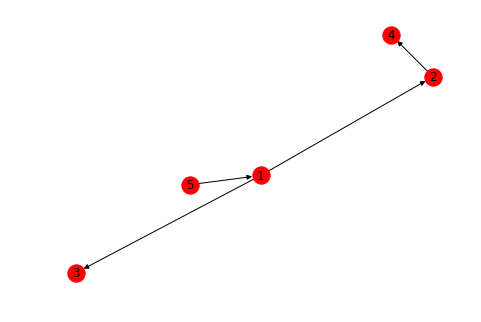

In [19]:
if False:
    import networkx as nx
    G = nx.DiGraph([(1, 2), (1, 3), (2, 4), (5,1)])
    nx.draw(G,with_labels=True) 
    #g1= nx.DiGraph([(y,x) for x,y in nx.immediate_dominators(G, 3).items()])
    #nx.draw(g1,with_labels=True) 
    for i in range(1,6):
        print(nx.immediate_dominators(G, i).items()) 


    a= [(y,x) for x,y in nx.immediate_dominators(G, 5).items()]         
    G_dominator=nx.DiGraph(a)
    cc=nx.dfs_successors(G_dominator, source=5,depth_limit=20)
    bbb=nx.descendants(G_dominator,source=2)
    print("Dom treee",cc)
    print("reachable",bbb)
            

In [9]:
class SSA_util():
    def __init__(self):
        pass
        
    def add_SSA_current_line(self):
        self.SSA_current_line+=1
        return self.SSA_current_line
    
    def get_SSA_current_line(self):
        return self.SSA_current_line       
    
    def add_SSA_table(self,x,bb):
        self.node[bb]["SSA_table"][x].append(self.get_SSA_current_line())
    
    def get_SSA_table_variable(self,x,bb):
        if x in self.node[bb]["SSA_table"].keys():
            pass
        else:
            #what about variables without initilization?
            return -1
        return self.node[bb]["SSA_table"][x][-1]
    def __repr__(self):
        return self.SSA_variable_table       

In [10]:
#for i in range(1,5):
#    print(b.next())

In [11]:
#Walrus-operator
#print(n:=3,n)